#  Modelling Uncertainity with Housing Data

* https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155
* https://www.databricks.com/blog/2022/04/28/how-wrong-is-your-model.html

# SETUP

In [193]:
from numpy import sqrt
from pandas import read_csv
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.11.1


In [236]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(path)
# print(df)
X, y =df.iloc[:,12], df.values[:, -1]

df1 = df
df1.columns=["F"+str(i) for i in range(0, len(df1.columns))]
print(df1)

          F0   F1     F2  F3     F4     F5    F6      F7  F8     F9   F10  \
0    0.02731  0.0   7.07   0  0.469  6.421  78.9  4.9671   2  242.0  17.8   
1    0.02729  0.0   7.07   0  0.469  7.185  61.1  4.9671   2  242.0  17.8   
2    0.03237  0.0   2.18   0  0.458  6.998  45.8  6.0622   3  222.0  18.7   
3    0.06905  0.0   2.18   0  0.458  7.147  54.2  6.0622   3  222.0  18.7   
4    0.02985  0.0   2.18   0  0.458  6.430  58.7  6.0622   3  222.0  18.7   
..       ...  ...    ...  ..    ...    ...   ...     ...  ..    ...   ...   
500  0.06263  0.0  11.93   0  0.573  6.593  69.1  2.4786   1  273.0  21.0   
501  0.04527  0.0  11.93   0  0.573  6.120  76.7  2.2875   1  273.0  21.0   
502  0.06076  0.0  11.93   0  0.573  6.976  91.0  2.1675   1  273.0  21.0   
503  0.10959  0.0  11.93   0  0.573  6.794  89.3  2.3889   1  273.0  21.0   
504  0.04741  0.0  11.93   0  0.573  6.030  80.8  2.5050   1  273.0  21.0   

        F11   F12   F13  
0    396.90  9.14  21.6  
1    392.83  4.03  34.7

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(y_train)

[45.4 13.4  9.6 14.3 23.1 16.7 18.5 15.4 16.8 31.7 23.2 19.9  8.4 13.4
 50.  33.4 22.7 24.6 23.9 16.6 15.2  6.3 22.6 22.5 18.5 21.5 18.  32.4
 21.7 24.7 23.1 18.9  7.4 20.1 19.9 16.2 23.  20.5 13.9 23.9 23.3 27.1
 18.3 14.5 14.9 27.1 42.8 13.4 14.9 19.5 50.  18.2 12.1 50.  20.7 20.6
 19.7 29.1 19.4 34.6 22.9 22.3 30.8 19.3 46.  20.4 10.5 28.5 21.6 31.2
 37.9 33.1  8.7 35.1 14.5 19.1 16.1 23.9 10.5 17.1 18.6  7.2 21.2 19.9
 42.3 14.1 14.2 22.5 37.  27.5 29.  20.8 32.  22.8 34.9 17.5 13.3  9.7
 21.8 17.8 11.7 21.  32.9 21.1  8.3 17.2 23.2 18.9 34.9 23.8 12.8 20.9
 26.5 24.8 20.3 38.7 13.8 15.  24.8 28.6 19.4 13.5 21.7 24.4 37.2 35.4
 11.  20.3 36.2 13.6 20.1 29.8 11.7 19.3 19.5 22.6 23.3 22.4 13.4 19.2
  7.5 22.2 16.2 20.  17.8 25.  25.  19.6 17.8 50.  21.7 23.6 22.  20.1
 23.3 37.6 46.7 31.5 24.5 50.  12.5 29.6 12.6 43.5 22.6 21.1 22.5 19.5
 28.1 32.  50.  19.6 20.9 19.1 21.9 24.3 10.4 22.   9.5 21.9 11.8 25.
 24.4 34.9 14.3 44.  23.5 24.8 19.7 31.6  5.6 18.6 27.5 26.6 15.6 11.9
 23.8 4

# 0. Data Exploration

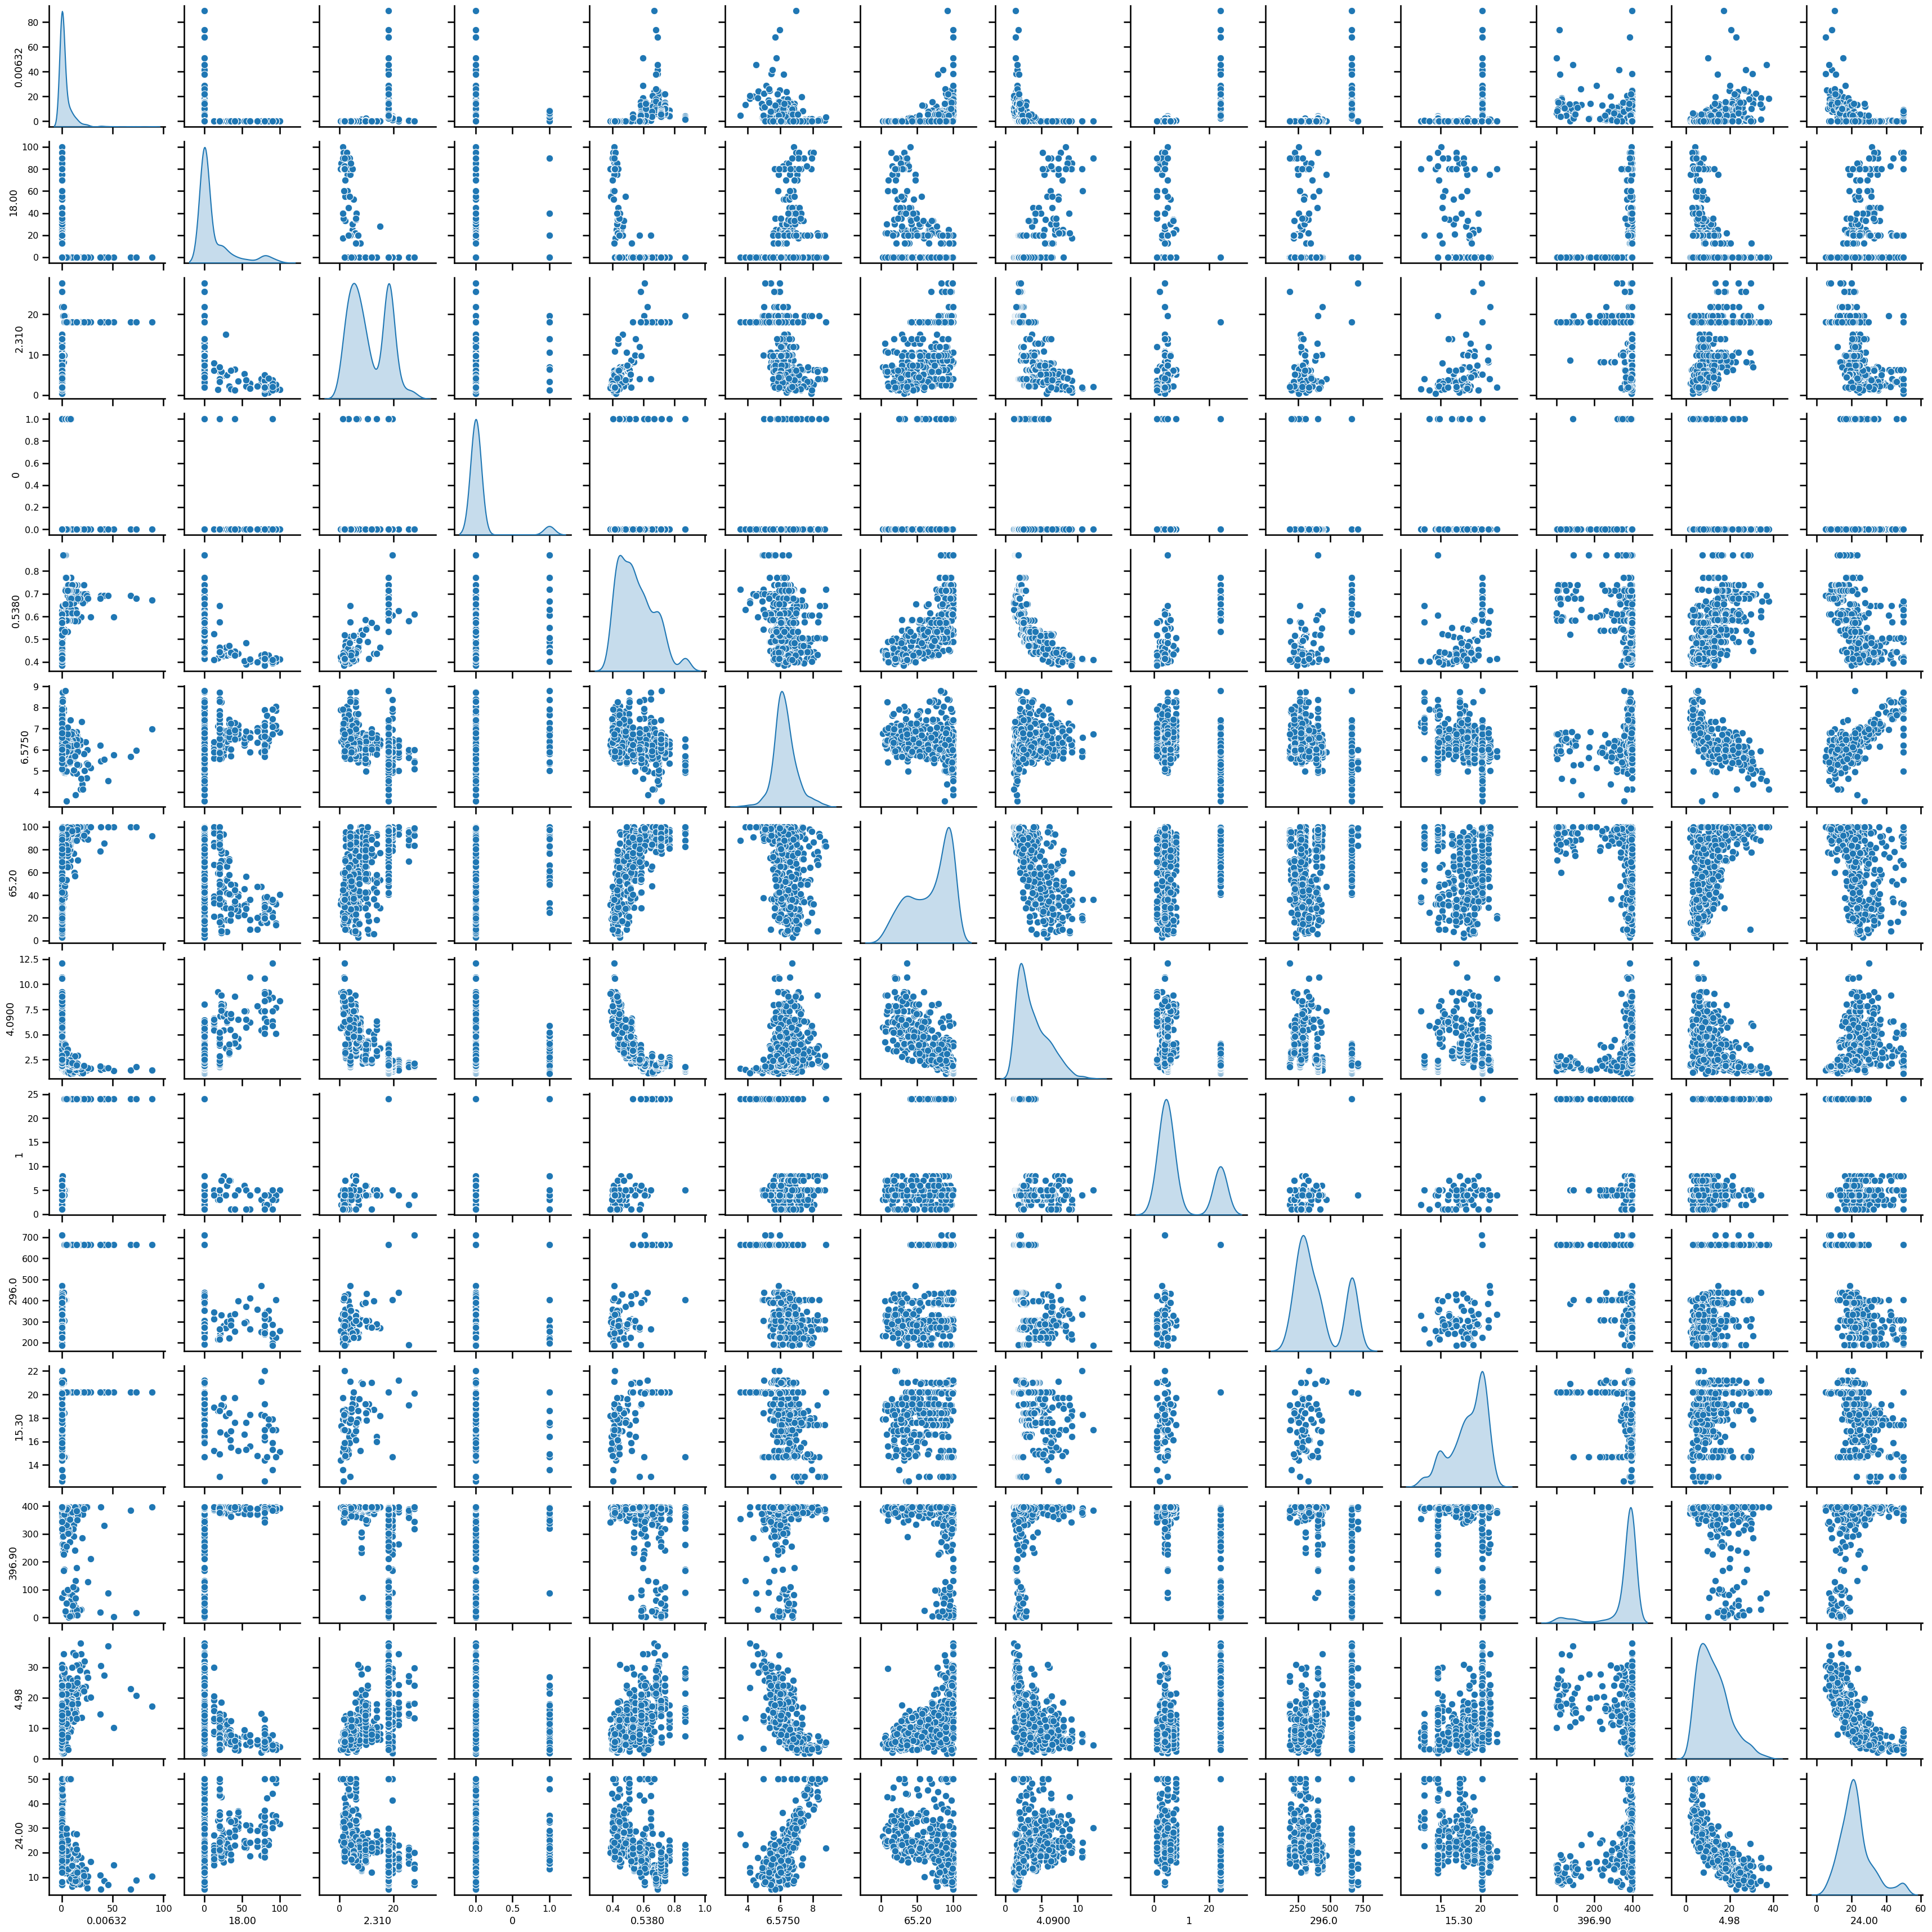

In [142]:
sns.pairplot(df, diag_kind='kde')

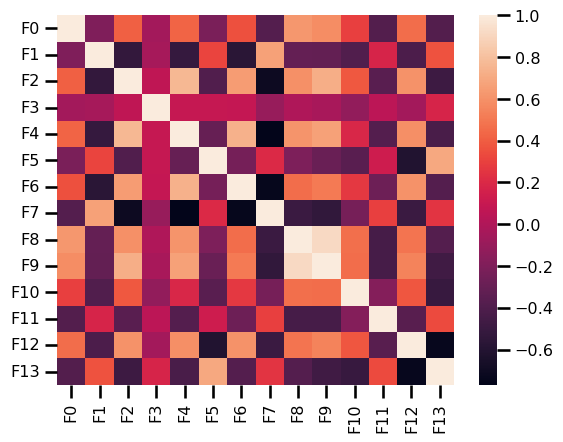

In [239]:
corrMatrix = df1.corr()
sns.heatmap(corrMatrix)

# Linear Regression

In [204]:
horsepower = np.array(df.iloc[:,12])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

In [205]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [207]:
%%time
history = horsepower_model.fit(
    X_train,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=0,
    #  Calculate validation results on 20% of the training data.
    validation_split = 0.2)

C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: total: 13.7 s
Wall time: 6.84 s


In [208]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

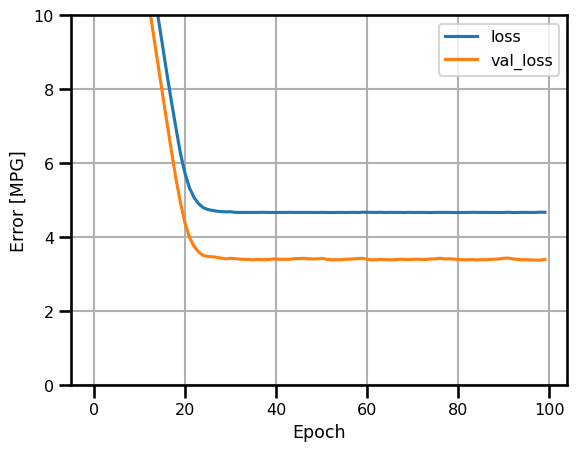

In [209]:
plot_loss(history)

In [222]:
x1 = tf.linspace(0.0, 50, 50)
y1 = horsepower_model.predict(x)

2/2 [==============================] - 0s 4ms/step


In [223]:
def plot_horsepower(x, y):
  plt.scatter(X_train,y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

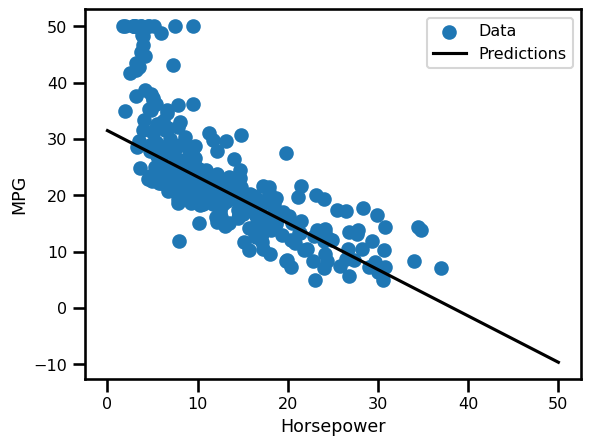

In [224]:
plot_horsepower(x1, y1)

# Multiple Linear regression with Tensorflow

In [174]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

ValueError: in user code:

    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\base_preprocessing_layer.py", line 122, in adapt_step  *
        self._adapt_maybe_build(data)
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\base_preprocessing_layer.py", line 295, in _adapt_maybe_build  **
        self.build(data_shape)
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\layers\preprocessing\normalization.py", line 187, in build
        raise ValueError(

    ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None], with unknown axis at index: 0


In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [173]:
linear_model.predict(X_train)

NameError: name 'linear_model' is not defined

# Linear Regression

In [213]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [214]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [215]:
dnn_horsepower_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_26 (Dense)            (None, 64)                128       
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [216]:
%%time
history = dnn_horsepower_model.fit(
    X_train,
    y_train,
    verbose=0, epochs=100,
 validation_split=0.2)

CPU times: total: 15.1 s
Wall time: 7.49 s


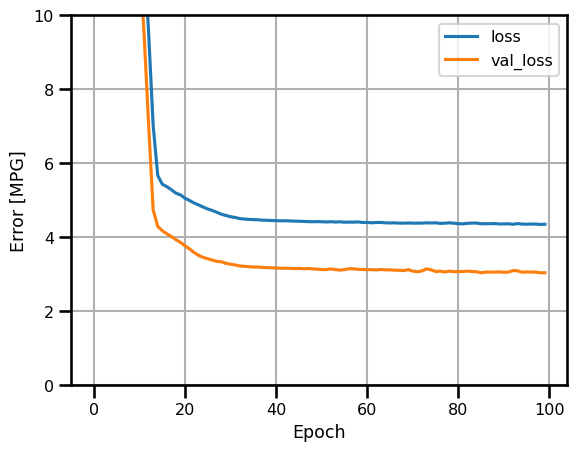

In [217]:
plot_loss(history)

In [225]:
x2 = tf.linspace(0.0, 50, 50)
y2 = dnn_horsepower_model.predict(x)

2/2 [==============================] - 0s 3ms/step


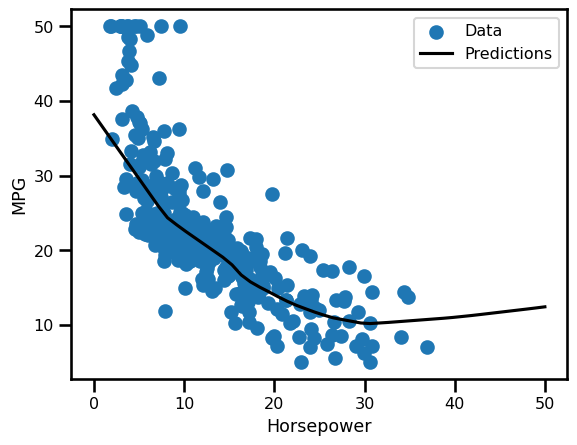

In [226]:
plot_horsepower(x2, y2)

In [241]:
df1['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    X_train, y_train,
    verbose=0)

print(df1['dnn_horsepower_model'])

0      3.822137
1      3.822137
2      3.822137
3      3.822137
4      3.822137
         ...   
500    3.822137
501    3.822137
502    3.822137
503    3.822137
504    3.822137
Name: dnn_horsepower_model, Length: 505, dtype: float64


# 1. Regular Tensorflow MLP Regression model

In [175]:
# mlp for regression
from numpy import sqrt
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import MaxPooling1D

# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = read_csv(path, header=None)
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]


# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features

# n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(50, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
# model.add(MaxPooling1D(2))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse')
# fit the model
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
# make a prediction
row = [0.00632,18.00,2.310,0,0.5380,6.5750,65.20,4.0900,1,296.0,15.30,396.90,4.98]
yhat = model.predict([row])
print('Predicted: %.3f' % yhat)

(339, 13) (167, 13) (339,) (167,)


ValueError: in user code:

    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\nkalimip\Anaconda3\envs\pred_est\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 339), found shape=(None, 13)


# 2. Tensorflow Probability

In [101]:
#@title Import { display-mode: "form" }

import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

In [102]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [122]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = pd.read_csv(path)#, header=None)
#print(df)
# x, y = df.values[:, :-1], df.values[:, -1]
x1 = df.iloc[:,12]
x = np.array([[n] for n in x1])
# x1 = df.iloc[:, [0,1,2]]
# print(x1)

y = df.values[:, -1]

x_train, x_tst, y_train, y_tst = train_test_split(x, y, test_size=0.33)
# print(x_tst)

     0.00632  18.00  2.310
0    0.02731    0.0   7.07
1    0.02729    0.0   7.07
2    0.03237    0.0   2.18
3    0.06905    0.0   2.18
4    0.02985    0.0   2.18
..       ...    ...    ...
500  0.06263    0.0  11.93
501  0.04527    0.0  11.93
502  0.06076    0.0  11.93
503  0.10959    0.0  11.93
504  0.04741    0.0  11.93

[505 rows x 3 columns]


In [106]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [107]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [108]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [109]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-1.6325103e+00  4.8055973e+01  4.1846107e+01  6.6401123e+01
 -4.2588320e+00 -6.2057704e-01 -2.0947132e+00  5.6832232e-02]
[-1.6425266 47.728428  41.878735  65.941826 ]


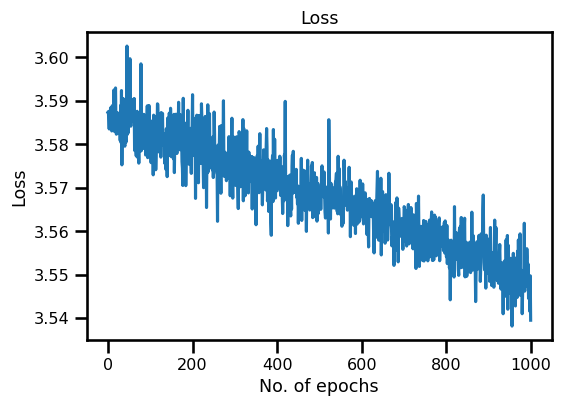

In [127]:
# Get the model
# Fit
history = model.fit(x_train, y_train, epochs=1000, verbose=0)

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()

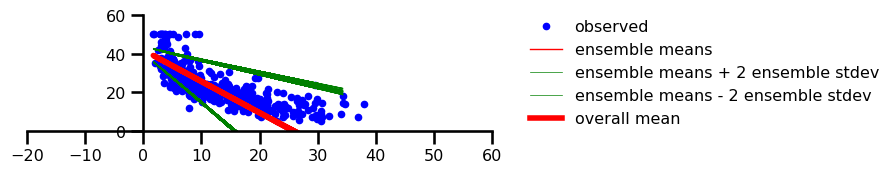

In [117]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,60);
# plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.savefig('tmp/housing.png', bbox_inches='tight', dpi=300)

In [118]:
df = pd.DataFrame({'A':[1,2,3],
                   'B':[4,5,6],
                   'C':[7,8,9],
                   'D':[1,3,5],
                   'E':[5,3,6],
                   'F':[7,4,3]})

print (df)
print(df.iloc[:,1])
   
# X = df.iloc[:, :-1].values
# print (X)
# print (X.shape)

   A  B  C  D  E  F
0  1  4  7  1  5  7
1  2  5  8  3  3  4
2  3  6  9  5  6  3
0    4
1    5
2    6
Name: B, dtype: int64
